In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
from anndata import AnnData, concat
import cloudpickle

In [2]:
import jax.numpy as jnp

In [3]:
import cellrank as cr
import scvelo as scv

In [4]:
from moscot.problems.time import TemporalNeuralProblem

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [5]:
org_adata = sc.read("/lustre/groups/ml01/workspace/monge_velo/data/benchmarks/gastrulation/adata_gastrulation.h5ad")
org_adata.obs['celltype'].unique()

leave_out = ['E6.5', 'E6.75', 'E7.0', 'E7.25', 'E7.5', 'E7.75', 'E8.0']
adata = org_adata[~org_adata.obs["stage"].isin(leave_out)].copy()

map_dict = {"E6.5": 6.5, "E6.75": 6.75, "E7.0": 7.0, "E7.25": 7.25, "E7.5": 7.5, "E7.75": 7.75, "E8.0": 8.0,
            "E8.25": 8.25, "E8.5": 8.5}
adata.obs["stage"] = adata.obs["stage"].copy().map(map_dict)

adata.obs = adata.obs.loc[:, ['stage', 'celltype']]
adata.var = adata.var[[]]

sc.pp.log1p(adata)

In [6]:
adata

AnnData object with n_obs × n_vars = 31403 × 53801
    obs: 'stage', 'celltype'
    uns: 'log1p'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'

In [7]:
tnp = TemporalNeuralProblem(adata)
tnp = tnp.score_genes_for_marginals("mouse", "mouse")

In [ ]:
tnp = tnp.prepare("stage", joint_attr="X_pca")
tnp = tnp.solve(tau_a=0.95, tau_b=0.95)

INFO     Solving problem BirthDeathNeuralProblem[stage='prepared', shape=(15042, 16361)].                          


 17%|███████████████████████████████████████▋                                                                                                                                                                                                 | 4264/25000 [3:34:34<17:20:59,  3.01s/it]

In [ ]:
with open("/lustre/groups/ml01/workspace/monge_velo/data/benchmarks/gastrulation/test_save_tnp", "wb") as f:
    cloudpickle.dump(tnp, f)

tnp

In [7]:
with open("/lustre/groups/ml01/workspace/monge_velo/data/benchmarks/gastrulation/test_save_tnp", "rb") as f:
    tnp = cloudpickle.load(f)

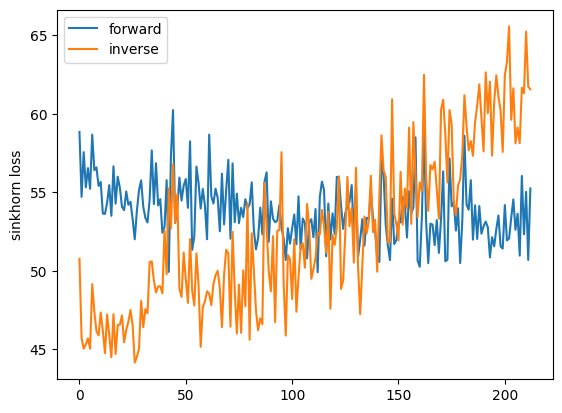

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(tnp[8.25, 8.5].solution._training_logs["valid_logs"]["sinkhorn_loss_forward"], label="forward")
ax.plot(tnp[8.25, 8.5].solution._training_logs["valid_logs"]["sinkhorn_loss_inverse"], label="inverse")
ax.set_ylabel("sinkhorn loss")
ax.legend()
plt.show()

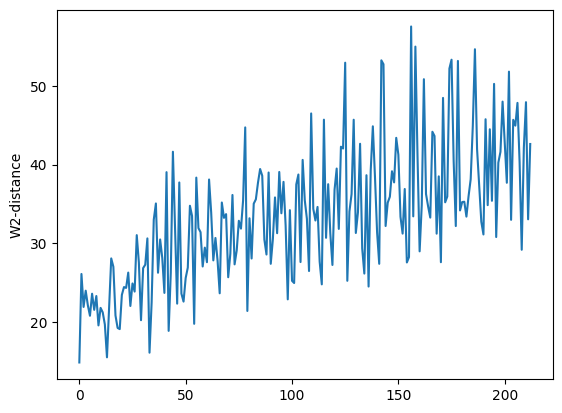

In [9]:
fig, ax = plt.subplots()
ax.plot(tnp[8.25, 8.5].solution._training_logs["valid_logs"]["valid_w_dist"])
ax.set_ylabel("W2-distance")
plt.show()

In [10]:
source = jnp.array(adata.obsm["X_pca"].copy())

In [11]:
velocity = tnp[8.25, 8.5].solution.push(source) - source

In [12]:
adata_result = AnnData(shape=velocity.shape)
adata_result.obs = adata.obs.copy()

In [13]:
adata_result.layers["GEX_velocity"] = np.asarray(velocity)
adata_result.layers["X_pca"] = np.asarray(adata.obsm["X_pca"])

In [14]:
adata_result

AnnData object with n_obs × n_vars = 31403 × 50
    obs: 'stage', 'celltype'
    layers: 'GEX_velocity', 'X_pca'

In [15]:
adata_result.write("/lustre/groups/ml01/workspace/monge_velo/data/benchmarks/gastrulation/adata_gex_velocities.h5ad")